In [1]:
from sympy import *
from sympy.core.numbers import Zero, One
from math import factorial as fac
import functools32

init_printing()

# Manual Munging

We'll need this later on...

Annoyingly, sympy does not pull free variables outside of integrals unless we call `doit()` to evaulate the integral. Without pulling out the factors of $\beta$ and $\lambda$, we won't be able to simplify the expressions. But, the call to `doit()` is extremely slow and the integrals can't be evaluated anyway. So, we'll write our own routine to pull out factors that are constant with respect to the integration.

In [2]:
def crawl(expr, func, *args, **kwargs):
    """Crawl the expression tree, and apply func to every node."""
    val = func(expr, *args, **kwargs)
    if val is not None:
        return val
    new_args = (crawl(arg, func, *args, **kwargs) for arg in expr.args)
    return expr.func(*new_args)


In [3]:
# Note that we're going to assume that the integral
# is expanded, so that inside of the integral is
# a product. We're then going to fish out terms that are constant
# with respect to the variable of integration. 
def fix_integral(expr):
    if expr.func == Integral:
        # if it's just an exponential, then do nothing
        if expr.args[0].func == exp:
            return None
        elif expr.args[0].func == Zero:
            return Zero()
        
        # otherwise, it should be a product
        # and we'll pull out anything constant
        # wrt the variable of integration
        assert expr.args[0].func == Mul
        inside = []
        outside = [1]
        for arg in expr.args[0].args:
            if expr.args[1][0] not in arg.free_symbols:
                outside.append(arg)
            else:
                inside.append(arg)
        val = Mul(*outside) * Integral(Mul(*inside), expr.args[1])
        return val
    if not expr.args:
        return expr
    else:
        return None

In [232]:
# This is the routine to call to simplify the integrals
def simplify_integral(expr):
    return expand(crawl(expand(expr), fix_integral))

We'll also create a simple function to truncate at a particular order. Note that this is a bit of a hack, in that it just sets the specified power of $\beta^N$ to zero. It doesn't do anything with any higher powers.

In [296]:
def truncate_order(expr, N):
    return expr.subs(beta**N, 0) + Function('O')(beta**N)

Now we'll define a function to rewrite the integrals as expecations. This function won't work for all general cases, but it's fine for our purposes here.

In [235]:
E = Function('E')

# Note that we're going to assume that the integral
# is expanded, so that inside of the integral is
# a product.
def extract_expectation_mv(expr):
    if expr.func == Integral:
        # it should be a product
        # and we'll pull out anything constant
        # wrt the variable of integration
        assert expr.args[0].func == Mul
        exp_terms = []
        non_exp_terms = []
        for arg in expr.args[0].args:
            if arg.func == exp:
                exp_terms.append(arg)
            else:
                non_exp_terms.append(arg)
        # we'll assume that the exp terms are always
        # the ones we need, so we won't look at them
        if not non_exp_terms:
            val = One()
        elif len(non_exp_terms) == 1:
            return E(non_exp_terms[0])
        else:
            return E(Mul(*non_exp_terms))
        return val
    if not expr.args:
        return expr
    else:
        return None

# Univariate Case

In [236]:
# these have assumptions about being real / positive that
# might help with simplifications
x = symbols('x', real=True)
beta = symbols('beta', positive=True)
l = symbols('lambda', real=True)
k = symbols('k', real=True)
H = Function('H')

In [237]:
def gen_moment(n, seperable=False):
    'Generate the nth moment'
    if n == 0:
        return 1.0
    else:
        if seperable:
            return integrate((l * H(x))**n * exp(-beta * l * H(x)), x) / integrate(exp(-beta * l * H(x)), x)
        else:
            return integrate(H(x, l)**n * exp(-beta * H(x, l)), x) / integrate(exp(-beta * H(x, l)), x)

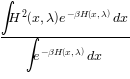

In [238]:
# we can have general lambda dependence
gen_moment(2)

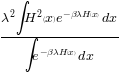

In [239]:
# or we can have it be seperable
gen_moment(2, True)

In [240]:
def binomial(x, y):
    'generate binomial coefficent'
    try:
        binom = fac(x) // fac(y) // fac(x - y)
    except ValueError:
        binom = 0
    return binom

@functools32.lru_cache()
def gen_cumulant(n, seperable=False):
    'generate the nth cumlant'
    k = gen_moment(n)
    for m in range(1, n):
        k -= binomial(n - 1, m - 1) * gen_cumulant(m, seperable) * gen_moment(n - m, seperable)
    return simplify_integral(k)

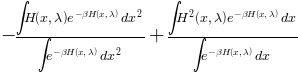

In [241]:
gen_cumulant(2)

In [242]:
def gen_delta_A(n, seperable=False):
    'generate a series expansion for the free energy to nth order'
    A = 0
    for i in range(1, n+1):
        A += beta**(i-1) / fac(i) * gen_cumulant(i, seperable)
    return A

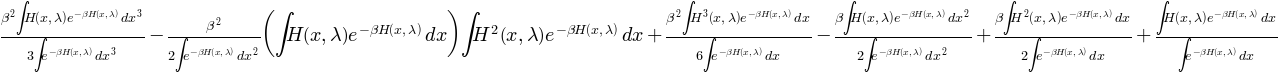

In [343]:
A_3 = simplify_integral(gen_delta_A(3))
A_3

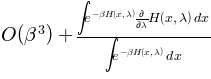

In [282]:
# now let's take the derivative
truncate_order(expand(simplify_integral(diff(A_3, l))), 3)

As you can see above, when we expand to 3rd order and take the derivative, we're left with $\langle\frac{\partial H}{\partial \lambda}\rangle$ and $O(\beta^3)$. If we expand to order $N$, we get this same term plus $O(\beta^N)$. This presumably holds to all orders, so $\frac{dA}{d\lambda} = \langle\frac{\partial H}{\partial \lambda}\rangle$ as expected.

We know that:
\begin{equation}
\frac{dA}{d\lambda} = \langle\frac{\partial H}{\partial \lambda}\rangle = \frac{\partial}{\partial \lambda}\langle H \rangle + \frac{\partial}{\partial \lambda} O(\beta).
\end{equation}
And we also know that:
\begin{equation}
\frac{\partial}{\partial \lambda} \langle H \rangle = \langle \frac{\partial H}{\partial \lambda}\rangle - \beta Cov\left(H, \frac{\partial H}{\partial \lambda}\right),
\end{equation}
which implies that
\begin{equation}
\frac{\partial}{\partial \lambda} O(\beta) = \beta Cov\left(H, \frac{\partial H}{\partial \lambda}\right).
\end{equation}


# Multivariate Case

In [14]:
# we need some more functions
H0 = Function('H0')
H1 = Function('H1')
H2 = Function('H2')

In [15]:
Q = symbols('Q')
R = symbols('R')
# this is the integral for an expactation, we can substitute in
# whatever we like for Q
expectation = ( integrate(Q(x, l) * exp(R(x,l)), x) /
                integrate(exp(R(x, l)), x))

@functools32.lru_cache()
def gen_moment_mv(n0, n1, n2, seperable=False):
    'generate moment of order n0, n1, n2'
    if seperable:
        expression = H0(x)**n0 * (l * H1(x))**n1 * (l * H2(x))**n2
        r = -beta * (H0(x) + l * H1(x) + l * H2(x))
    else:
        expression = H0(x)**n0 * H1(x, l)**n1 * H2(x, l)**n2
        r = -beta * (H0(x) + H1(x, l) + H2(x, l))
    subbed = expectation.subs(Q(x, l), expression).subs(R(x, l), r)
    return subbed

In [96]:
def partition(collection):
    'generate all partitions of a set'
    if len(collection) == 1:
        yield [ collection ]
        return

    first = collection[0]
    for smaller in partition(collection[1:]):
        # insert `first` in each of the subpartition's subsets
        for n, subset in enumerate(smaller):
            yield smaller[:n] + [[ first ] + subset]  + smaller[n+1:]
        # put `first` in its own subset 
        yield [ [ first ] ] + smaller


@functools32.lru_cache()        
def gen_cumulant_mv(n0, n1, n2, seperable=False):
    'generate multivariate cumulant of order n0, n1, n2 in H0, H1, H2'
    powers = [0] * n0 + [1] * n1 + [2] * n2
    part = partition(powers)
    summation = 0
    for grouping in part:
        prod = 1
        q = len(grouping)
        for term in grouping:
            pow0 = sum(1 for x in term if x == 0)
            pow1 = sum(1 for x in term if x == 1)
            pow2 = sum(1 for x in term if x == 2)
            moment = gen_moment_mv(pow0, pow1, pow2, seperable)
            prod = prod * moment
        summation += (-1)**(q-1) * fac(q-1) * prod
    return summation

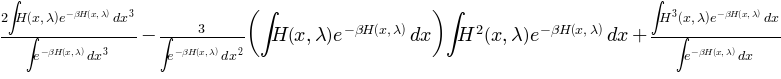

In [97]:
# let's test it out
gen_cumulant(3)

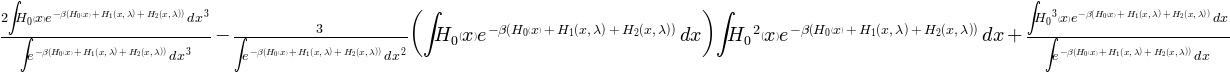

In [99]:
# this looks right
gen_cumulant_mv(3, 0, 0)

In [318]:
def partition_n(n):
    for i in range(n + 1):
        for j in range(n + 1):
            for k in range(n + 1):
                if i + j + k == n:
                    yield i, j, k


def coeff_ATotal(i, j, k, n):
    return 1


def coeff_A0(i, j, k, n):
    if i > 0:
        return 1
    else:
        return 0


def coeff_A1(i, j, k, n):
    if i > 0:
        return 0
    else:
        return Rational(j, j+k)


def coeff_A1_pred(i, j, k, n):
    if j > 0:
        return 1
    else:
        return 0

    
def coeff_A2(i, j, k, n):
    if i > 0:
        return 0
    else:
        return Rational(k, j+k)


coeff_dict = {
    'ATotal': coeff_ATotal,
    'A0': coeff_A0,
    'A1': coeff_A1,
    'A1pred': coeff_A1_pred,
    'A2': coeff_A2
}


@functools32.lru_cache()
def gen_delta_A_mv(N, seperable=False, component='ATotal'):
    total = 0
    for n in range(1, N+1):
        for i, j, k in partition_n(n):
            total += (beta**(n-1) / 
                      fac(n) * 
                      coeff_dict[component](i, j, k, n) *
                      fac(n) / (fac(i) * fac(j) * fac(k)) *
                      gen_cumulant_mv(i, j, k, seperable))
    return total
            

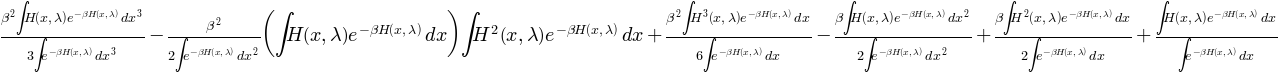

In [156]:
# now let's check to see that if we set H! and H@ to zero,
# we get the same result as the univariate case
x1 = simplify_integral(gen_delta_A_mv(3))
x1 = x1.subs(H1(x,l), 0).subs(H2(x,l), 0).subs(H0(x), H(x,l))
x1 = simplify_integral(x1)
x1

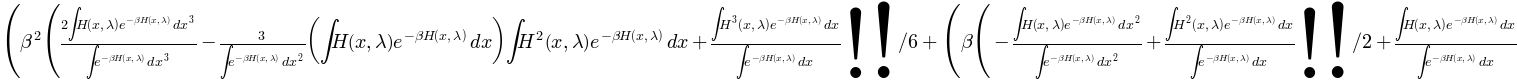

In [157]:
x2 = gen_delta_A(3)
x2

In [158]:
# it looks like these match
simplify(x1 - x2)

# Seperable Case

First, we'll look at the seperable case. For each component of the free energy, we will perform expansions up to the 4th order.

We'll start with expansions of $A_{Total}$.

In [283]:
dAT_1 = expand(simplify(simplify_integral(diff(gen_delta_A_mv(1, seperable=True, component='ATotal'), l))))
dAT_2 = expand(simplify(simplify_integral(diff(gen_delta_A_mv(2, seperable=True, component='ATotal'), l))))
dAT_3 = expand(simplify(simplify_integral(diff(gen_delta_A_mv(3, seperable=True, component='ATotal'), l))))
dAT_4 = expand(simplify(simplify_integral(diff(gen_delta_A_mv(4, seperable=True, component='ATotal'), l))))

In [284]:
truncate_order(expand(simplify(crawl(dAT_1, extract_expectation_mv))), 1)

In [285]:
truncate_order(expand(simplify(crawl(dAT_2, extract_expectation_mv))), 2)

In [286]:
truncate_order(expand(simplify(crawl(dAT_3, extract_expectation_mv))), 3)

In [287]:
truncate_order(expand(simplify(crawl(dAT_4, extract_expectation_mv))), 4)

We can see that we end up with $\frac{\partial}{\partial\lambda}A_{Total} = \langle \frac{\partial H_1}{\partial\lambda} \rangle + \langle \frac{\partial H_2}{\partial\lambda} \rangle + O(\beta^N)$ as we expect.

Next, well try this for $A_1$. In order for all of the other terms to cancel, we must get the splitting factors correct.

In [209]:
dA1_1 = expand(simplify(simplify_integral(diff(gen_delta_A_mv(1, seperable=True, component='A1'), l))))
dA1_2 = expand(simplify(simplify_integral(diff(gen_delta_A_mv(2, seperable=True, component='A1'), l))))
dA1_3 = expand(simplify(simplify_integral(diff(gen_delta_A_mv(3, seperable=True, component='A1'), l))))
dA1_4 = expand(simplify(simplify_integral(diff(gen_delta_A_mv(4, seperable=True, component='A1'), l))))

In [288]:
truncate_order(expand(simplify(crawl(dA1_1, extract_expectation_mv))), 1)

In [289]:
truncate_order(expand(simplify(crawl(dA1_2, extract_expectation_mv))), 2)

In [290]:
truncate_order(expand(simplify(crawl(dA1_3, extract_expectation_mv))), 3)

In [291]:
truncate_order(expand(simplify(crawl(dA1_4, extract_expectation_mv))), 4)

With the correct splitting, we obtain the expected $\frac{\partial}{\partial\lambda}A_{1} = \langle \frac{\partial H_1}{\partial\lambda} \rangle + O(\beta^N)$. The results for $A_2$ have a change of variable, but are otherwise identical (not shown).

Next, we examine the results for the spectator component $H_0$.

In [224]:
dA0_1 = expand(simplify(simplify_integral(diff(gen_delta_A_mv(1, seperable=True, component='A0'), l))))
dA0_2 = expand(simplify(simplify_integral(diff(gen_delta_A_mv(2, seperable=True, component='A0'), l))))
dA0_3 = expand(simplify(simplify_integral(diff(gen_delta_A_mv(3, seperable=True, component='A0'), l))))
dA0_4 = expand(simplify(simplify_integral(diff(gen_delta_A_mv(4, seperable=True, component='A0'), l))))

In [292]:
truncate_order(expand(simplify(crawl(dA0_1, extract_expectation_mv))), 1)

In [293]:
truncate_order(expand(simplify(crawl(dA0_2, extract_expectation_mv))), 2)

In [294]:
truncate_order(expand(simplify(crawl(dA0_3, extract_expectation_mv))), 3)

In [295]:
truncate_order(expand(simplify(crawl(dA0_4, extract_expectation_mv))), 4)

As expected, with the correct splitting, these terms are zero.

# Non-Separable Case

Now, let's do the same thing, but with the non-separable case.

We expect to get $\langle \frac{\partial H_1}{\partial\lambda} \rangle + \langle \frac{\partial H_2}{\partial\lambda} \rangle$.

In [297]:
dAT_1_ns = expand(simplify(simplify_integral(diff(gen_delta_A_mv(1, seperable=False, component='ATotal'), l))))
dAT_2_ns = expand(simplify(simplify_integral(diff(gen_delta_A_mv(2, seperable=False, component='ATotal'), l))))
dAT_3_ns = expand(simplify(simplify_integral(diff(gen_delta_A_mv(3, seperable=False, component='ATotal'), l))))x
# only to rhird order to save time
#dAT_4_ns = expand(simplify(simplify_integral(diff(gen_delta_A_mv(4, seperable=True, component='ATotal'), l))))

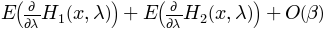

In [298]:
truncate_order(expand(simplify(crawl(dAT_1_ns, extract_expectation_mv))), 1)

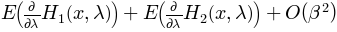

In [299]:
truncate_order(expand(simplify(crawl(dAT_2_ns, extract_expectation_mv))), 2)

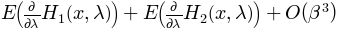

In [300]:
truncate_order(expand(simplify(crawl(dAT_3_ns, extract_expectation_mv))), 3)

Good, we got the expected result, although that was mostly just a sanity check.

Now, for the real test let's compute $\frac{\partial}{\partial\lambda}A_1$. We've assumed a particular spltting of the cumulant expansion and now we're going to see what we get for the derivative in the cass where we have arbitrary $\lambda$ depedence. The hope is that we get some simple expression that looks like $\langle \frac{\partial H_1}{\partial\lambda} \rangle$ with a correction that contains only a few low order terms.

In [305]:
dA1_1_ns = expand(simplify(simplify_integral(diff(gen_delta_A_mv(1, seperable=False, component='A1'), l))))
dA1_2_ns = expand(simplify(simplify_integral(diff(gen_delta_A_mv(2, seperable=False, component='A1'), l))))
dA1_3_ns = expand(simplify(simplify_integral(diff(gen_delta_A_mv(3, seperable=False, component='A1'), l))))
dA1_4_ns = expand(simplify(simplify_integral(diff(gen_delta_A_mv(4, seperable=False, component='A1'), l))))

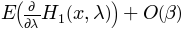

In [306]:
truncate_order(expand(simplify(crawl(dA1_1_ns, extract_expectation_mv))), 1)

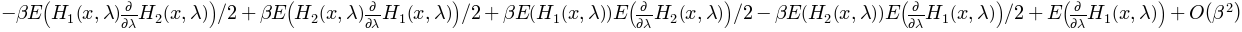

In [307]:
truncate_order(expand(simplify(crawl(dA1_2_ns, extract_expectation_mv))), 2)

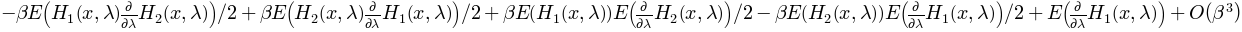

In [308]:
truncate_order(expand(simplify(crawl(dA1_3_ns, extract_expectation_mv))), 3)

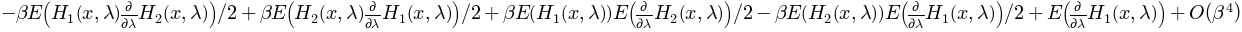

In [309]:
truncate_order(expand(simplify(crawl(dA1_4_ns, extract_expectation_mv))), 4)

Sweet! Our conjecture is correct. This gives us a way to provide the same splitting for arbitrary paths and it only involves computing two covariances.

# Predictive coefficients

One thing we may wish to do is to predict the free energy with a certain component set to zero from a simulation where all components are scaled. This leads to a prediction error:
\begin{equation}
\epsilon = \Delta A_1 - \left( \Delta A_{T, 1, 1, 1} - \Delta A_{T, 1, 0, 1} \right),
\end{equation}

where the subscripts on the $A_T$ terms indicate the presence or absence of $H_0$, $H_1$, and $H_2$.

The Brady-like splitting above is not ideal for this prediction, as the coupling between $H_1$ and the other Hamilontian terms is spread "evenly", so the $\Delta A_1$ terms will not fully cancel with terms from $\Delta_{T, 1, 1, 1}$.

Another splitting that would be better for this prediction is for _all_ components containing $H_1$ to end up in $\Delta A_1$. In this case, $\Delta A_1$ will fully cancel with $\Delta_{T, 1, 1, 1}$. This will leave $\epsilon$ as the difference between the cumulant terms not containing $H_1$ evaluated in two different ensembles. The downside is that the sum of the components is no longer the total free energy, as we've counted some of the components multiple times.

Now, le's see what we get as a derivative.

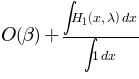

In [322]:
A1_1_pred = gen_delta_A_mv(1, seperable=False, component='A1pred')
truncate_order(simplify_integral(A1_1_pred), 1)

In [329]:
A1_2_pred = gen_delta_A_mv(2, seperable=False, component='A1pred')
truncate_order(crawl(simplify_integral(A1_2_pred), extract_expectation_mv), 2)

In [330]:
A1_3_pred = gen_delta_A_mv(3, seperable=False, component='A1pred')
truncate_order(crawl(simplify_integral(A1_3_pred), extract_expectation_mv), 3)

In [335]:
dA1_1_pred = expand(simplify(simplify_integral(diff(gen_delta_A_mv(1, seperable=False, component='A1pred'), l))))
dA1_2_pred = expand(simplify(simplify_integral(diff(gen_delta_A_mv(2, seperable=False, component='A1pred'), l))))
dA1_3_pred = expand(simplify(simplify_integral(diff(gen_delta_A_mv(3, seperable=False, component='A1pred'), l))))
dA1_4_pred = expand(simplify(simplify_integral(diff(gen_delta_A_mv(4, seperable=False, component='A1pred'), l))))

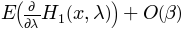

In [336]:
truncate_order(expand(simplify(crawl(dA1_1_pred, extract_expectation_mv))), 1)

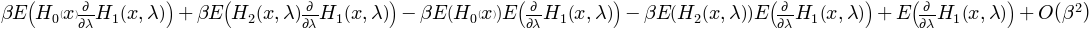

In [337]:
truncate_order(expand(simplify(crawl(dA1_2_pred, extract_expectation_mv))), 2)

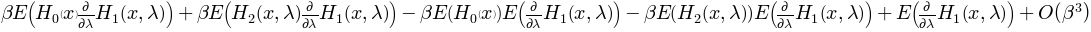

In [338]:
truncate_order(expand(simplify(crawl(dA1_3_pred, extract_expectation_mv))), 3)

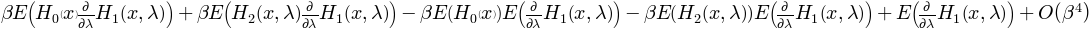

In [339]:
truncate_order(expand(simplify(crawl(dA1_4_pred, extract_expectation_mv))), 4)

So, this looks good. We correct $\langle \frac{\partial H_1}{\partial\lambda} \rangle$ by some covariances involving the other Hamiltonain components.